# SoptSC

**Language:** R

**Paper:** Wang, S., et al., Cell lineage and communication network inference via optimization for single-cell transcriptomics. Nucleic Acids Res, 2019. 47(11): p. e66.

**Code Resource:** https://mkarikom.github.io/RSoptSC/articles/RSoptSC.html

**Claiming:** Inference of intercellular signaling networks (ligand-receptor/ regulatory direction)

**Method:** Computes signaling probabilities between sender cells (expressing ligand) and receiver cells (expressing receptor and exhibiting differential target gene activity)

**Database:** Information of pathway of interest: one table with ligand-receptor combinations and another with receptor-target-up or down regulation combinations


## Input
1. scRNA-seq data: gene-expression matrix (raw) with rows as genes and columns as cells
2. vector of gene names
3. vector of cell ids



## Installation

In [ ]:
install.packages("devtools")
library(devtools)
install_github("mkarikom/RSoptSC")

This is an example on a set of skin cells.

### Load and Preprocess Data

In [1]:
library(RSoptSC)
df <- system.file("extdata", "GSE67602_JoostData.csv.bz2", package = "RSoptSC")
gf <- system.file("extdata", "GSE67602_JoostGenes.csv.bz2", package = "RSoptSC")
cf <- system.file("extdata", "GSE67602_JoostCells.csv.bz2", package = "RSoptSC")
af <- system.file("extdata", "GSE67602_JoostAnnotation.csv.bz2", package = "RSoptSC")

GSE67602_Joost <- LoadData(df, gf, cf, af)

In [6]:
str(GSE67602_Joost$data)
str(GSE67602_Joost$annotation)

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:1722015] 0 1 2 3 5 9 10 12 21 22 ...
  ..@ p       : int [1:721] 0 1553 3187 5097 6356 7608 10940 13778 15638 18013 ...
  ..@ Dim     : int [1:2] 24470 720
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:24470] "ERCC-00002" "ERCC-00003" "ERCC-00004" "ERCC-00009" ...
  .. ..$ : chr [1:720] "X1772067055_A01" "X1772067055_A03" "X1772067055_A04" "X1772067055_A05" ...
  ..@ x       : num [1:1722015] 363 20 276 25 1 2 3 1 10 9 ...
  ..@ factors : list()
 chr [1:720] "Basal" "IFE-DI" "Basal" "Basal" "Basal" "Basal" "Basal" ...


In [2]:
# Remove Spike-in RNA
gene_names <- GSE67602_Joost$gene_names
spikein <- grep('ERCC', gene_names)
gene_names <- gene_names[-spikein]
data <- GSE67602_Joost$data[-spikein,]
# Apply number of features and exclusion threshold
logdata <- log10(data + 1)
gene_expression_threshold <- 0.03
n_features <- 3000
filtered_data <- SelectData(logdata, gene_expression_threshold, n_features)

### Compute the Similarity Matrix

In [7]:
# Run L2R2 on the processed data, outputting the number of iterations and value of the objective
S <- SimilarityM(lambda = 0.05, 
                 data = filtered_data$M_variable,
                 dims = 3,
                 pre_embed_method = 'tsne',
                 perplexity = 20, 
                 pca_center = TRUE, 
                 pca_scale = TRUE)

[1] "Err = 20.5455897001755"
[1] "Err = 19.4702780087087"
[1] "Err = 18.4265199659475"
[1] "Err = 17.4425717265801"
[1] "Err = 16.5202539857201"
[1] "Err = 15.6563631163014"
[1] "Err = 7.75323681950709"
[1] "Err = 0.414255424322379"
[1] "Err = 0.356193431753237"
[1] "Err = 0.338671465506275"
[1] "Err = 0.328128710797043"
[1] "Err = 0.317858040832273"
[1] "Err = 0.307428006129498"
[1] "Err = 0.297129756449178"
[1] "Err = 0.287113842245664"
[1] "Err = 0.277436399949304"
[1] "Err = 0.268111474482939"
[1] "Err = 0.253604224310093"
[1] "Err = 0.23226321190246"
[1] "Err = 0.204632560237053"
[1] "Err = 0.170932937639855"
[1] "Err = 0.130853522056673"
[1] "Err = 0.0837178365494444"
[1] "Err = 0.041909362880327"
[1] "Err = 0.100284185027065"
[1] "convergence by error min"


In [8]:
# Compute distances on the similarity matrix. If the truncated graph has multiple components, join them to allow inter-cluster distance estimation.
low_dim_mapping <- RepresentationMap(similarity_matrix = S$W,
                                      flat_embedding_method = 'tsne',
                                      join_components = TRUE,
                                      perplexity = 35,
                                      theta = 0.5,
                                      normalize = FALSE,
                                      pca = TRUE,
                                      pca_center = TRUE,
                                      pca_scale = TRUE,
                                      dims = 2,
                                      initial_dims = 2)

### Cluster the Cells

Warning message in sqrt(S[i] * termn) * uun:
“Recycling array of length 1 in array-vector arithmetic is deprecated.
  Use c() or as.vector() instead.
”
Warning message in sqrt(S[i] * termn) * vvn:
“Recycling array of length 1 in array-vector arithmetic is deprecated.
  Use c() or as.vector() instead.
”
Warning message in sqrt(S[i] * termn) * uun:
“Recycling array of length 1 in array-vector arithmetic is deprecated.
  Use c() or as.vector() instead.
”
Warning message in sqrt(S[i] * termn) * vvn:
“Recycling array of length 1 in array-vector arithmetic is deprecated.
  Use c() or as.vector() instead.
”
Warning message in sqrt(S[i] * termp) * uup:
“Recycling array of length 1 in array-vector arithmetic is deprecated.
  Use c() or as.vector() instead.
”
Warning message in sqrt(S[i] * termp) * vvp:
“Recycling array of length 1 in array-vector arithmetic is deprecated.
  Use c() or as.vector() instead.
”
Warning message in sqrt(S[i] * termn) * uun:
“Recycling array of length 1 in array-vecto

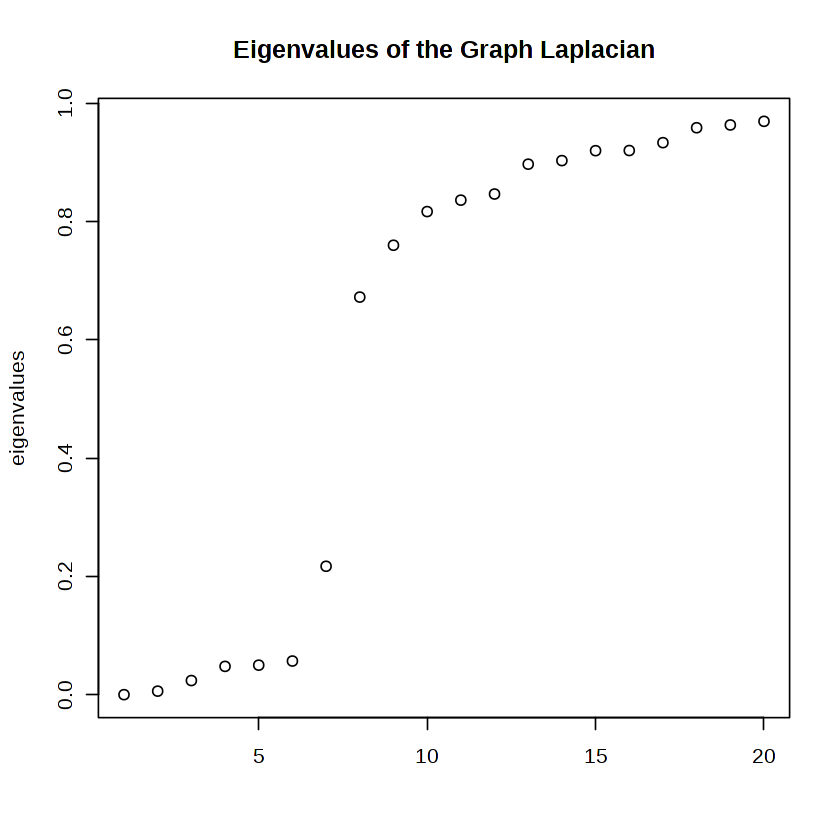

In [9]:
# Cluster the cells by factoring the similarity matrix. Infer cluster number using spectra of the ensemble Laplacian
clusters <- ClusterCells(similarityMatrix = S$W, n_comp = 15, .options='p')
H <- clusters$H
labels <- clusters$labels
n_clusters <- length(unique(clusters$labels))

plot(c(1:20), 
     clusters$ensemble$eigs$val[1:20],
     xlab = NA,
     ylab = 'eigenvalues',
     main = 'Eigenvalues of the Graph Laplacian')

### Visualize the Clusters

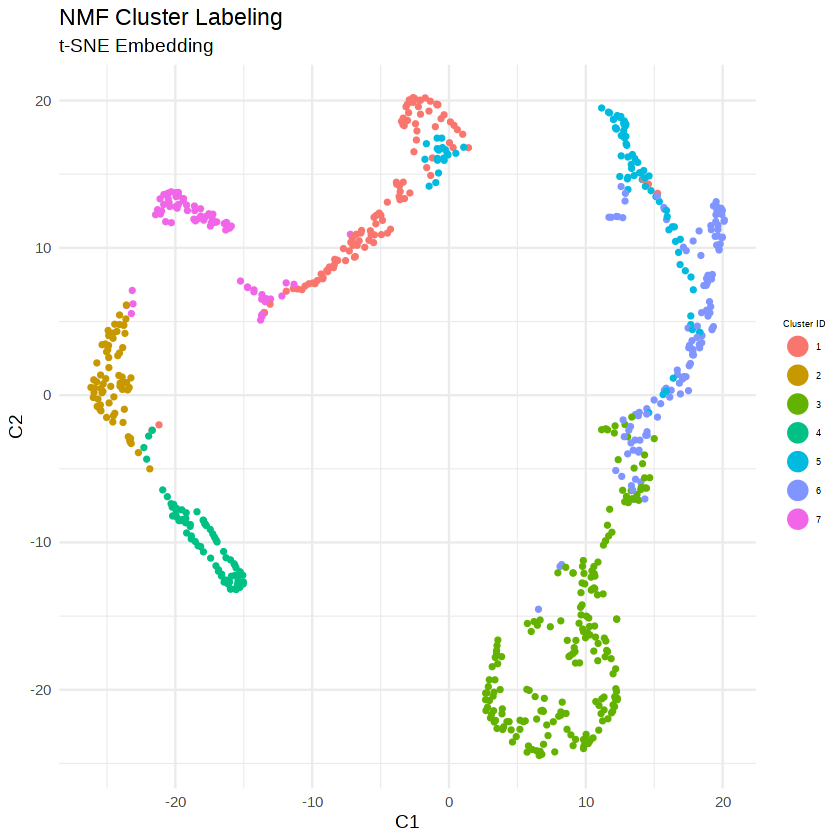

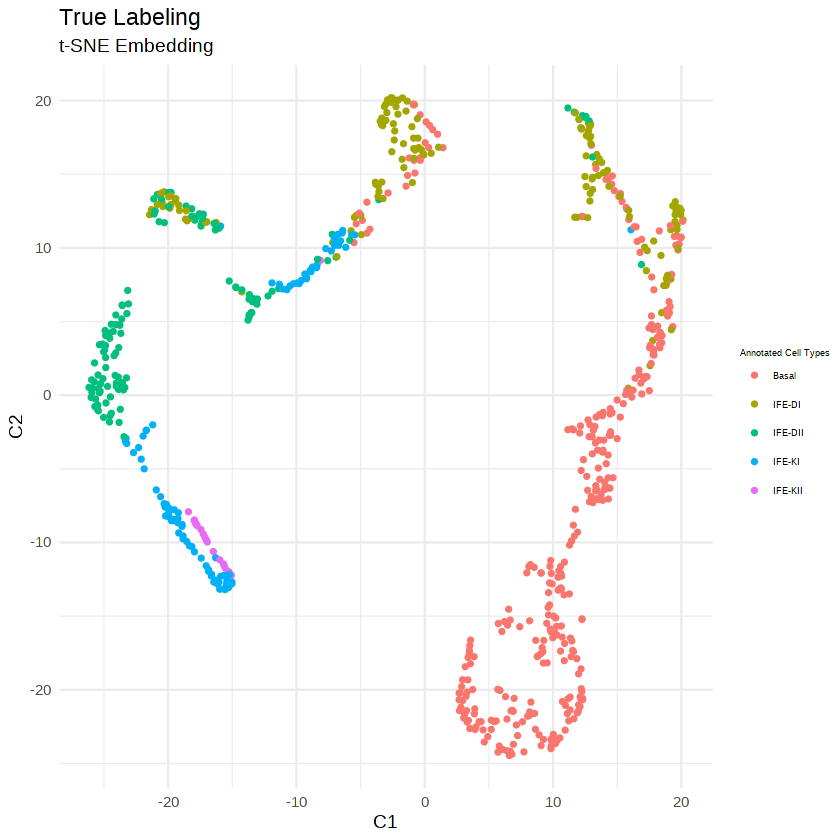

In [11]:
# define a scheme for the coloring.  This is a required parameter for plotting discrete (factor) data
colorscale <- ColorHue(n = length(unique(labels)))
colorscale <- colorscale$hex.1.n.

# plot clusters
FeatureScatterPlot(flat_embedding = low_dim_mapping$flat_embedding,
                         feature = as.factor(labels),
                         title = "NMF Cluster Labeling",
                         subtitle = "t-SNE Embedding",
                         featurename = "Cluster ID",
                         colorscale = colorscale)
true_labels <- GSE67602_Joost$annotation
# plot clusters
FeatureScatterPlot(flat_embedding = low_dim_mapping$flat_embedding,
                         feature = as.factor(true_labels),
                         title = "True Labeling",
                         subtitle = "t-SNE Embedding",
                         featurename = "Annotated Cell Types")

### Find cluster marker genes

Joining, by = "geneSymbol"

Joining, by = "fac_barcode"



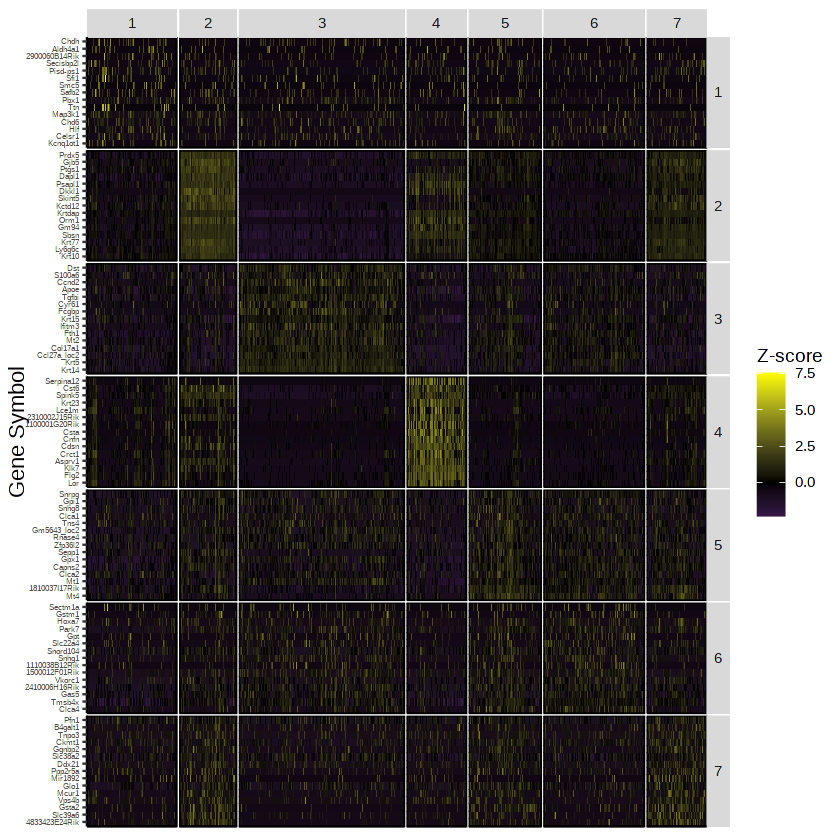

In [12]:
markers <- GetMarkerTable(counts_data = logdata,
                            cluster_labels = labels,
                            H = H,
                            n_sorted = 25)

PlotTopN_Grid(data = logdata,
              cluster_labels = labels,
              markers = markers$all,
              n_features = 15)

### Analyze Signaling Mediated by a Ligand-Receptor Family
There are two tables needed to specify prior knowledge of the pathway:

    ligand-receptor interactions. link: RSoptSC/inst/extdata/tgfb_lig_rec.tsv

    receptor-target interactions. link: RSoptSC/inst/extdata/tgfb_rec_target.tsv

SoptSC requires the paths of these two files to be passed to ImportPathway() as shown below:

In [22]:
library(knitr)
library(kableExtra)

lig_rec_path <- system.file("extdata", "tgfb_lig_rec.tsv", package = "RSoptSC")
rec_target_path <- system.file("extdata", "tgfb_rec_target_both.tsv", package = "RSoptSC")
pathway <- ImportPathway(lig_table_path = lig_rec_path,
                         rec_table_path = rec_target_path,
                         data = logdata,
                         gene_names = gene_names)
head(pathway$pathway_removed)

,receptor,ligand,target,direction
,<chr>,<chr>,<chr>,<chr>
1,Tgfbr1,Tgfb1,Zeb2,up
2,Tgfbr1,Tgfb1,Smad2,up
3,Tgfbr1,Tgfb1,Wnt4,up
4,Tgfbr1,Tgfb1,Wnt11,up
5,Tgfbr1,Tgfb1,Bmp7,up
6,Tgfbr1,Tgfb1,Sox9,up


We then compute the probability of intercellular interaction based on this pathway.

In [19]:
datamat = as.matrix(logdata); rownames(datamat) = tolower(rownames(datamat)); colnames(datamat) = tolower(colnames(datamat))
pathway$pathway_removed$receptor = tolower(pathway$pathway_removed$receptor)
pathway$pathway_removed$ligand = tolower(pathway$pathway_removed$ligand)
pathway$pathway_removed$target = tolower(pathway$pathway_removed$target)
names(labels) = tolower(names(labels))
  
Pmats <- GetSignalingPartners(datamat,labels,pathway)


 up and down targets detected, directions =  up down , all(dirs=='up')= FALSE
 using parallel update
 up and down targets detected, directions =  up down , all(dirs=='up')= FALSE
 using parallel update
 up and down targets detected, directions =  up down , all(dirs=='up')= FALSE
 using parallel update
 up and down targets detected, directions =  up down , all(dirs=='up')= FALSE
 using parallel update

### Plot of Intercellular Network
It seems that SoptSC doesn't have any function to output circos or direction plots as the article showed.
All I can find is the function *SigPlot()* to produce a plot of a cell signaling network according to the cell-normalized expression score. 

Joining, by = "Var2"

Joining, by = "Var1"

Joining, by = "Var1"

Joining, by = "Var2"

Joining, by = c("cluster.Var1", "cluster.Var2")

Joining, by = c("cluster.Var1", "cluster.Var2")

Joining, by = c("cluster.Var1", "cluster.Var2")

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


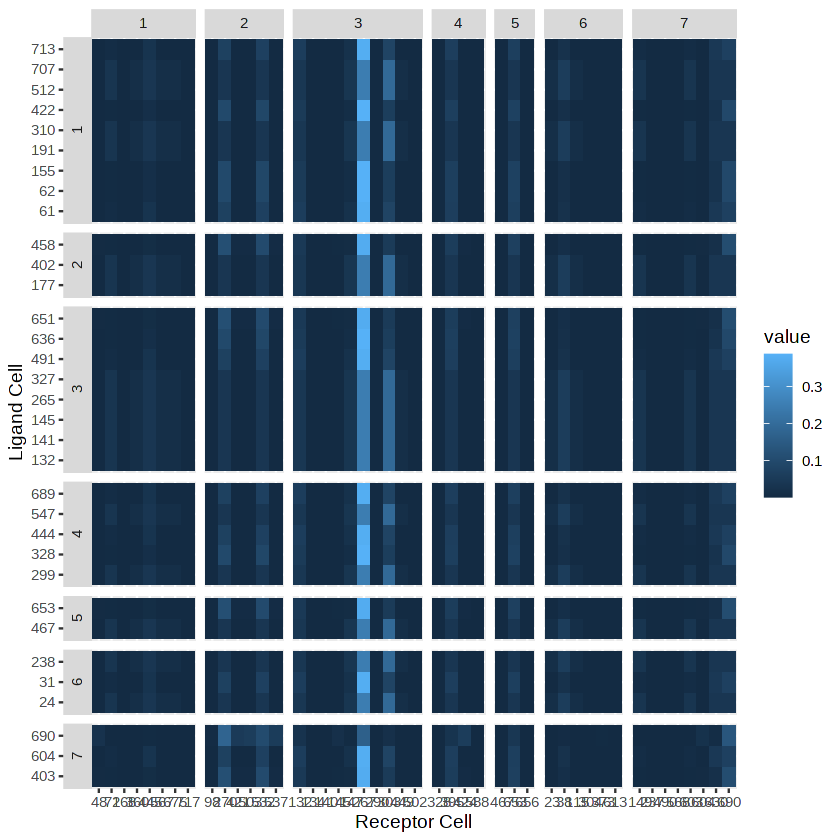

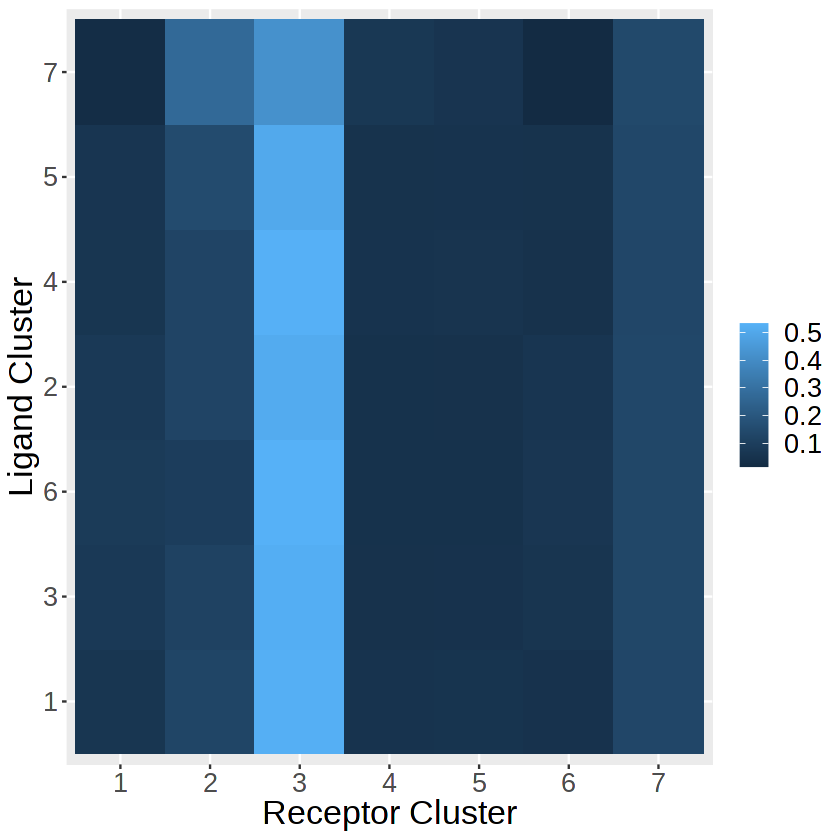

In [23]:
SigPlot(Pmats$P_tot,labels)
cluster_P <- ClusterSig(Pmats,
                        cluster_labels = labels)
SigPlot_Cluster(cluster_P$P_tot,
                c(1:n_clusters))

Last updated: June 12,2021